<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, root_scalar
from copy import deepcopy
import subprocess
import pathlib

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
print_tables = False    # Output tables can be printed or omitted

rad2deg = 180/np.pi
deg2rad = np.pi/180

# **Tidal stream design**
## The problem is divided in subproblems:


1. Glauert optimal distribution (inviscid flow solution)
2.   List item
3.
4.


## Class that stores the blade section data for the 4 parts of the solution

In [ ]:
class BladeData:

    def CosDist( self, i: int, n: int, ang0_deg: float = 0 ) -> float:
        '''
        Generates a cosine blade section spacing
        '''

        if i == n-1: return 1
        if i == 0: return 0
        csi0 = ang0_deg * deg2rad
        dcsi = ( np.pi - 2 * csi0 ) * i / ( n-1 )
        return ( ( np.cos( np.pi - csi0 - dcsi ) + 1.0 ) * 0.5 )


    def __init__( self, λ_hub: float, λ_tip: float, n: int, linear:bool=False ):
        '''
        λ_hub: hub speed ratio
        λ_tip: tip speed ratio
        n: number of blade sections
        linear: True if the blade sections spacing is linear
        '''

        if linear:
            self.λ_vec = np.linspace( λ_hub, λ_tip, n )
        else:
            self.λ_vec = np.zeros( n )
            for i in range( n ):
                self.λ_vec[i] = ( λ_tip - λ_hub ) * self.CosDist( i, n ) + λ_hub

        self.n = n                      # number of blade sections
        self.λ_hub = λ_hub              # hub speed ratio
        self.λ_tip = λ_tip              # tip speed ratio

        self.a_vec  = np.zeros( n )     # axial induction factor
        self.ap_vec = np.zeros( n )     # tangential induction factor
        self.k_vec  = np.zeros( n )     # Prandtl's tip correction
        self.ϕ0_vec = np.zeros( n )     # relative velocity angle
        self.σ_vec  = np.zeros( n )     # solidity factor
        self.CP_vec = np.zeros( n )     # power coefficient
        self.CP_tip = 0.0

        self.α_vec  = np.zeros( n )     # angle of attack
        self.CL_vec = np.zeros( n )     # lift coefficient
        self.CD_vec = np.zeros( n )     # drag coefficient
        self.θ_vec  = np.zeros( n )     # pitch angle

## Blade span config

In [ ]:
Z = 3           # number of blades
_λ_hub = 0.5    # hub speed ratio
_λ_tip = 5.0    # tip speed ratio
_dλ = 0.1       # increment of λ

# number of sections for the linear case
n = int( ( _λ_tip - _λ_hub ) / _dλ + 0.5 ) + 1

print( f'{n} sections with r_hub / R_tip = {_λ_hub/_λ_tip:0.3f}' )

46 sections with r_hub / R_tip = 0.100


## The current notebook only considers blades with a single blade section geometry



In [4]:
class DemoHydrofoil:
    '''
    Hydrofoil section data given by a simple equation
    '''

    def design_angle( self ):
        return 6.08178

    def alpha_limits( self ):
        return -15, 15

    def data( self, α ):
        # max( CL/CD ) -> α = 6.08178
        CL = 0.368 + 0.094 * α
        CD = 3.31333E-3 + (8.63333E-5 + 3.51666E-5 * α) * α
        return CL, CD

In [7]:
cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/"
         "main/Tidal_Stream/BladeElementMethod/Foils/DU93-W-210_polar.txt" )

In [8]:
class HydrofoilFromFile:
    '''
    Hydrofoil section data from a file
    '''

    def __init__( self, filename ):

        # df = pd.read_csv( filename, skiprows=[0,1,2,3], usecols=[0,1,3], \
        #                        names=['alpha', 'CL', 'CD'], sep='\s+' )
        df = pd.read_csv( filename, sep=r'\s+' )
        self.alpha = df['alpha'].to_numpy()
        self.CL = df['CL'].to_numpy()
        self.CD = df['CD'].to_numpy()

        CLCD = self.CL / self.CD
        i = np.argmax( CLCD )
        self.α_opt = self.alpha[i]

    def design_angle( self ):
        return self.α_opt

    def alpha_limits( self ):
        return self.alpha[0], self.alpha[-1]

    def data( self, α ):
        CL = np.interp( α, self.alpha, self.CL )
        CD = np.interp( α, self.alpha, self.CD )
        return CL, CD

In [11]:
Hydrofoil = HydrofoilFromFile( 'DU93-W-210_polar.txt' )
# Hydrofoil = DemoHydrofoil()

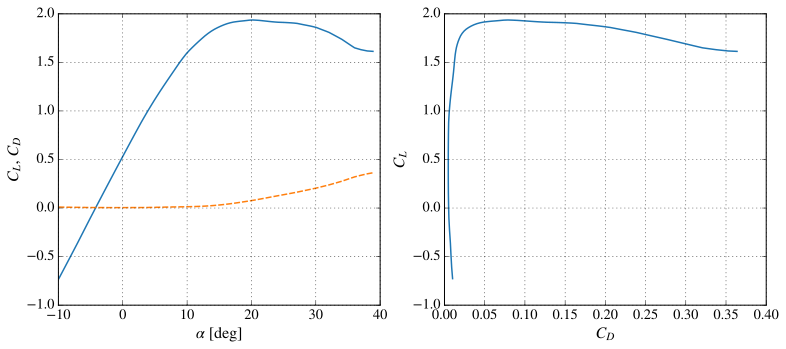

In [12]:
_alpha_vec = np.linspace( *Hydrofoil.alpha_limits(), 100 )
_CL_vec, _CD_vec = Hydrofoil.data( _alpha_vec )

mpl.subplots(nrows=1, ncols=2, figsize=(12,5) )
mpl.subplot(1,2,1)
mpl.plot( _alpha_vec, _CL_vec )
mpl.plot( _alpha_vec, _CD_vec )
mpl.grid()
mpl.xlabel( r"$\alpha$ [deg]")
mpl.ylabel( r"$C_L$, $C_D$")

mpl.subplot(1,2,2)
mpl.plot( _CD_vec, _CL_vec )
mpl.grid()
mpl.xlabel( r"$C_D$")
mpl.ylabel( r"$C_L$");

### Airfoil design conditions

In [16]:
α_des  = Hydrofoil.design_angle()
CL_des, CD_des = Hydrofoil.data( α_des )
print( f'α_des = {α_des:.2f}°, CL_des = {CL_des:.3f}, CD_des = {CD_des:.3f}' )

α_des = 3.00°, CL_des = 0.898, CD_des = 0.005


# **Part 1** - Glauert optimal distribution (inviscid flow solution)

In [ ]:
dti = BladeData( _λ_hub, _λ_tip, n )    # data for inviscid flow

C_P = 0.5675 -> Glauert


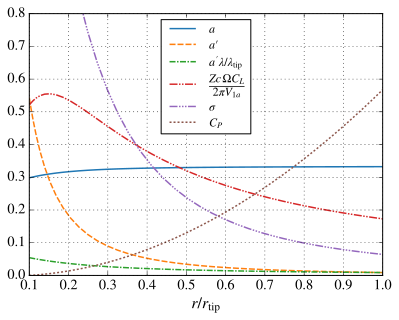

In [ ]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar( func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ0 = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCL  = 4.0 * ap * λ / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ0_vec[i] = ϕ0
    dti.σ_vec[i] = σCL / CL_des

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( 1 - 3*dti.a_vec[i], 1 - 3*dti.a_vec[i-1], dti.λ_tip )

x_vec = dti.λ_vec / dti.λ_tip

mpl.plot( x_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( x_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, dti.ap_vec*dti.λ_vec/dti.λ_tip, label = r"$a'\lambda/\lambda_\mathrm{tip}$" )
mpl.plot( x_vec, dti.σ_vec* CL_des *dti.λ_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, dti.σ_vec, label = r"$\sigma$" )
mpl.plot( x_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/r_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {dti.CP_vec[-1]:.4f} -> Glauert" )

In [ ]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi_0$": dti.ϕ0_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dti.σ_vec*CL_des*dti.λ_vec,
                     r"$\sigma$": dti.σ_vec
                    } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    df

## Computing the turbine blade (Glauert's solution)

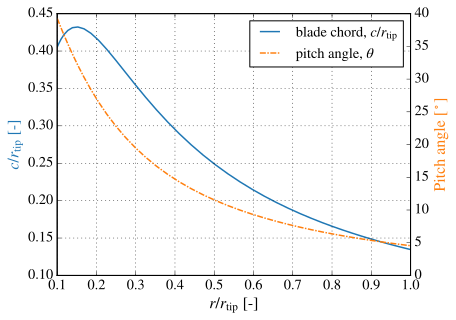

In [ ]:
σ_factor = 2.0 * np.pi / Z

θ_vec = dti.ϕ0_vec - α_des
cR_vec = dti.σ_vec * σ_factor *  dti.λ_vec / dti.λ_tip
rR_vec = dti.λ_vec / dti.λ_tip

ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/r_\mathrm{tip}$" )
ax1.set_ylabel( r"$c/r_\mathrm{tip}$ [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/r_\mathrm{tip}$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade.pdf" )

In [ ]:
def tip_loss( a, ap, ϕ0, λ, λtip ):
    ff = 0.5 * Z * np.abs( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / ( 1 - a ) )**2 )
    rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )
    return rr

In [ ]:
# The initial viscous solution is the invisc flow results
dtv = deepcopy( dti ) # deepcopy avoids references

for i, λ in enumerate( dti.λ_vec ):

    ϕ = np.atan( 1 / λ )
    a = dti.a_vec[i]
    ap = dti.ap_vec[i]
    σ = dti.σ_vec[i]

    for j in range( 400 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        Ca = CL_des * cosϕ0 + CD_des * sinϕ0
        Ct = CL_des * sinϕ0 - CD_des * cosϕ0

        a  = σ * Ca / ( 4 * sinϕ0**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ0*cosϕ0 - σ * Ct )

        if np.abs( a - a_mo ) < 1E-6 and np.abs( ap - ap_mo ) < 1E-6:
            break

    k = tip_loss( a, ap, ϕ0, λ, dtv.λ_tip )

    dtv.ϕ0_vec[i] = ϕ0
    dtv.a_vec[i] = a
    dtv.ap_vec[i] = ap
    dtv.k_vec[i] = k
    dtv.σ_vec[i] = dti.σ_vec[i]
    dtv.θ_vec[i] = ϕ0 - α_des

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dtv.λ_tip**2
for i in range( 1, len( dti.λ_vec ) ):
    k = i - 1
    d_λ = ( dtv.λ_vec[i] - dtv.λ_vec[k] )
    f_k = dtv.k_vec[k] * dtv.ap_vec[k] * ( 1 - dtv.a_vec[k] ) * dtv.λ_vec[k]**3
    f_i = dtv.k_vec[i] * dtv.ap_vec[i] * ( 1 - dtv.a_vec[i] ) * dtv.λ_vec[i]**3
    dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

C_P = 0.4792 -> Viscous flow


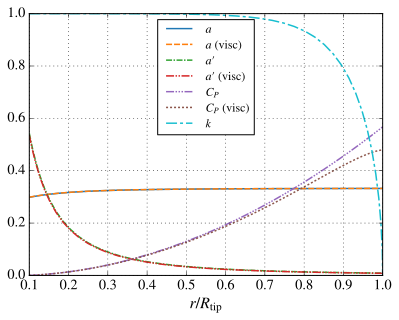

In [ ]:
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
mpl.plot( rR_vec, dtv.k_vec,  label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )
mpl.savefig( "InductionFactors.pdf" )

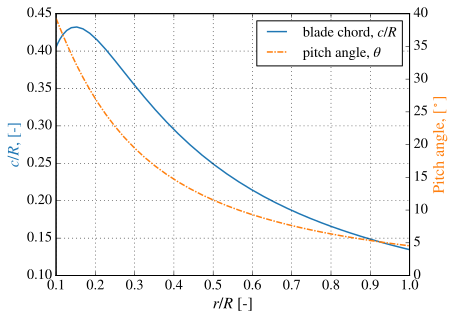

In [ ]:
cR_vec = dtv.σ_vec * σ_factor *  dtv.λ_vec / dtv.λ_tip
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.figure(4)
ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade_visc.pdf" )

In [ ]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                        r"$a$": dtv.a_vec,
                        r"$a'$": dtv.ap_vec,
                        r"$\phi_0$": dtv.ϕ0_vec*rad2deg,
                        r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dtv.σ_vec*CL_des*dtv.λ_vec,
                        r"$\sigma$": dtv.σ_vec
                        } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    df

In [ ]:
λ_off = 6

rat = λ_off / _λ_tip
dta = Data( _λ_hub * rat, _λ_tip * rat, dtv.n )


rf = 0.5 # relaxation factor
om_rf = 1 - rf
a = ap = ϕ0 = α = CL = CD = error = 0
Found = False

for i, λ in enumerate( dta.λ_vec ):

    if i == 0:
        a  = dtv.a_vec[i]
        ap = dtv.ap_vec[i]

    σ = dti.σ_vec[i]
    θ = dtv.θ_vec[i]

    for j in range( 400 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        α = ϕ0 - θ
        CL, CD = Hydrofoil.data( α )

        Ca = CL * cosϕ0 + CD * sinϕ0
        Ct = CL * sinϕ0 - CD * cosϕ0

        a = σ * Ca / (4 * np.sin(ϕ0) ** 2 + σ * Ca)

        # Spera's correction, PDF pp. 316
        ac = 1/3
        if a >= ac:
            KK = (4 * np.sin(ϕ0)**2) / (σ * Ca)
            to_sqrt = np.abs( (KK*(1 - 2*ac) + 2)**2 + 4*(KK * ac**2 - 1) )
            a = 1 + 0.5*KK*(1 - 2*ac) - 0.5 * np.sqrt(to_sqrt)

        ap = σ * Ct / (4 * sinϕ0*cosϕ0 - σ * Ct)

        a = rf * a + a_mo * om_rf
        ap = rf * ap + ap_mo * om_rf

        error = np.max( (np.abs( a - a_mo ), np.abs( ap - ap_mo ) ) )

        if error < 1E-6:
            Found = True
            break

    if not Found:
        print( f'ERROR max = {error:.4E}' )

    # rR = λ / dta.λ_tip
    # print( f'\ti = {i}, ϕ0 = {ϕ0*rad2deg:.4f}, α = {α*rad2deg:.4f} a = {a:.6f}, ap = {ap:.6f}, r/R = {rR:.6f}' )

    k = tip_loss( a, ap, ϕ0, λ, dta.λ_tip )

    dta.a_vec[i] = a
    dta.ap_vec[i] = ap
    dta.k_vec[i] = k
    dta.σ_vec[i] = σ
    dta.ϕ0_vec[i] = ϕ0

    dta.α_vec[i] = α
    dta.CL_vec[i] = CL
    dta.CD_vec[i] = CD

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dta.λ_tip**2
for i in range( 1, len( dta.λ_vec ) ):
    k = i - 1
    d_λ = ( dta.λ_vec[i] - dta.λ_vec[k] )
    f_k = dta.k_vec[k] * dta.ap_vec[k] * ( 1 - dta.a_vec[k] ) * dta.λ_vec[k]**3
    f_i = dta.k_vec[i] * dta.ap_vec[i] * ( 1 - dta.a_vec[i] ) * dta.λ_vec[i]**3
    dta.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"λ_off = {λ_off:.2f}, C_P = {CP:.4f} -> Viscous flow" )

λ_off = 6.00, C_P = 0.4222 -> Viscous flow


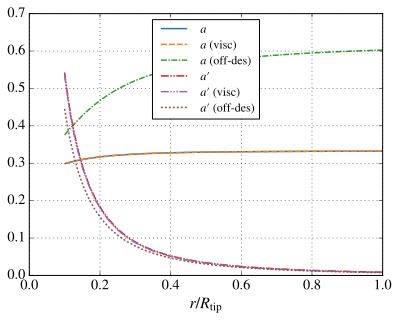

In [ ]:
rR_vec = dta.λ_vec / dta.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dta.a_vec,  label = r"$a$ (off-des)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dta.ap_vec, label = r"$a\prime$ (off-des)" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()

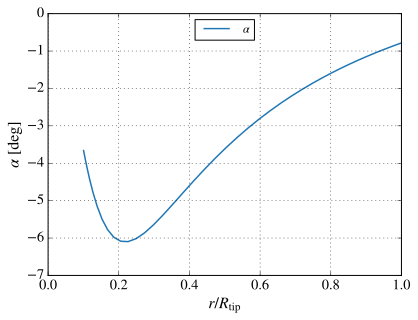

In [ ]:
rR_vec = dta.λ_vec / dta.λ_tip

mpl.plot( rR_vec, dta.α_vec*rad2deg,  label = r"$\alpha$" )
mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( r"$\alpha$ [deg]")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()

In [ ]:
if print_tables:

    df = pd.DataFrame( { r"$\lambda$": dta.λ_vec,
                        r"$a$": dta.a_vec,
                        r"$a'$": dta.ap_vec,
                        r"$\phi_0$": dta.ϕ0_vec*rad2deg,
                        r"$\kappa$": dta.k_vec,
                        r"$\sigma$": dta.σ_vec,
                        r"$\alpha$": dta.α_vec*rad2deg,
                        r"$C_L$": dta.CL_vec,
                        r"$C_D$": dta.CD_vec,
                        } )

    # print( df.to_latex(index=False,
    #        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
    #                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
    # ))
    df

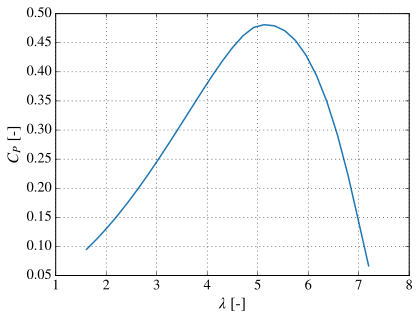

In [ ]:
λ_off_min = 1.6
λ_off_max = 7.2
dλ_off = 0.2

no = int( (λ_off_max - λ_off_min) / dλ_off + 0.5 )
λ_off_vec = np.linspace( λ_off_min, λ_off_max, no )
CP_off_vec = []

for λ_off in λ_off_vec:

    rat = λ_off / _λ_tip
    dta = Data( _λ_hub * rat, _λ_tip * rat, dtv.n )

    rf = 0.5 # relaxation factor
    om_rf = 1 - rf
    a = ap = ϕ0 = α = CL = CD = error = 0
    Found = False

    for i, λ in enumerate( dta.λ_vec ):

        if i == 0:
            a  = dtv.a_vec[i]
            ap = dtv.ap_vec[i]

        σ = dti.σ_vec[i]
        θ = dtv.θ_vec[i]

        for j in range( 400 ):

            a_mo = a
            ap_mo = ap

            ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
            cosϕ0 = np.cos( ϕ0 )
            sinϕ0 = np.sin( ϕ0 )

            α = ϕ0 - θ
            CL, CD = Hydrofoil.data( α )

            Ca = CL * cosϕ0 + CD * sinϕ0
            Ct = CL * sinϕ0 - CD * cosϕ0

            a = σ * Ca / (4 * np.sin(ϕ0) ** 2 + σ * Ca)

            # Spera's correction, PDF pp. 316, see also Hansen PDF pp. 60
            ac = 1/3
            if a >= ac:
                KK = (4 * np.sin(ϕ0)**2) / (σ * Ca)
                to_sqrt = np.abs( (KK*(1 - 2*ac) + 2)**2 + 4*(KK * ac**2 - 1) )
                a = 1 + 0.5*KK*(1 - 2*ac) - 0.5 * np.sqrt(to_sqrt)

            ap = σ * Ct / (4 * sinϕ0*cosϕ0 - σ * Ct)

            a = rf * a + a_mo * om_rf
            ap = rf * ap + ap_mo * om_rf

            error = np.max( (np.abs( a - a_mo ), np.abs( ap - ap_mo ) ) )

            if error < 1E-6:
                Found = True
                break

        if not Found:
            print( f'ERROR max = {error:.4E}' )

        k = tip_loss( a, ap, ϕ0, λ, dta.λ_tip )

        dta.a_vec[i] = a
        dta.ap_vec[i] = ap
        dta.k_vec[i] = k
        dta.σ_vec[i] = σ
        dta.ϕ0_vec[i] = ϕ0

        dta.α_vec[i] = α
        dta.CL_vec[i] = CL
        dta.CD_vec[i] = CD

    # integrate CP using trapezoidal rule
    CP = 0
    fct = 8 / dta.λ_tip**2
    for i in range( 1, len( dta.λ_vec ) ):
        k = i - 1
        d_λ = ( dta.λ_vec[i] - dta.λ_vec[k] )
        f_k = dta.k_vec[k] * dta.ap_vec[k] * ( 1 - dta.a_vec[k] ) * dta.λ_vec[k]**3
        f_i = dta.k_vec[i] * dta.ap_vec[i] * ( 1 - dta.a_vec[i] ) * dta.λ_vec[i]**3
        dta.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

    CP_off_vec.append( CP )

mpl.plot( λ_off_vec, CP_off_vec )
mpl.xlabel( r"$\lambda$ [-]")
mpl.ylabel( r"$C_P$ [-]")
mpl.grid()